In [1]:
# Import stuff
import pystan
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.interpolate as interpolate
import netCDF4
from models.stan_dlm_models import *
%matplotlib inline

In [2]:
# Compile the DLM model: this translates the stan model in stan_dlm_models.py into C++ and compiles it
# Note: this step may take a few minutes
model_kalman_ar1 = pystan.StanModel(model_code=code_kalman_ar1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ce0cf070d48949045c8df5a0c7d92012 NOW.


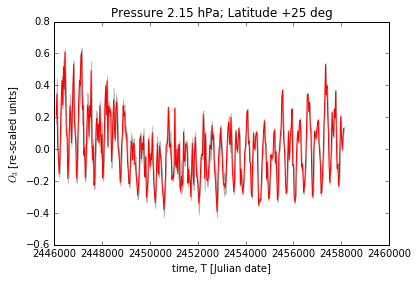

In [3]:
# Import the data 
# You can do this however you like but the end result must be the following variables loaded in:
# N (int) = number of time-steps in the time-series
# d float[N] = the data time-series (IMPORTANT: NaNs are NOT allowed, for missing values please set those data to zero and set
# the corresponding error for those data points to something very large, like 10^20)
# s float[N] = std-deviation error-bars on each data point (set error bars for missing values to a large number; see above)

# Import data from a netCDF
data = netCDF4.Dataset('data/BASIC_V1_2017_lotus_seascyc_gcsw2017_fac2.nc')

# Extract time, pressure and latitude variables from the netCDF
T = data['time'][:]
P = data['pressure'][:]
L = data['latitude'][:]

# Which pressure and latitude index do you want to analyze?
pressure = 22
latitude = 8

# How many time steps are there? (ie how long is the time-series)
N = len(T)

# Pick out a pressure and latitude panel: this is the "data" time-series from the netCDF
d = data['o3'][:, pressure, latitude]

# Extract the error-bars on the time-series from the netCDF
s = data['o3_sigma'][:, pressure, latitude]

# IMPORTANT: The DLM is set-up to run on mean subtracted data re-scaled to have a dynamic range of unity
# NB: We must re-scale the data here and re-scale back to the original units after the DLM run, look out for this later

# Mean subtract and re-scale the data so it has dynamic range of unity, 
# Apply same scaling transform to the std-dev error bars
scale = max(d) - min(d)
mean = np.mean(d)
d = d - mean
d = d/scale
s = s/scale

# Plot the selected data and error bars
plt.title('Pressure {:.2f} hPa; Latitude {:+.0f} deg'.format(P[pressure], L[latitude]))
plt.plot(T, d, color = 'red')
plt.fill_between(T, d - s, d + s, color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [re-scaled units]')
plt.show()

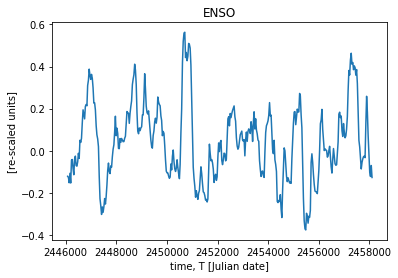

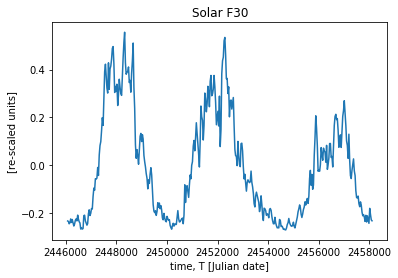

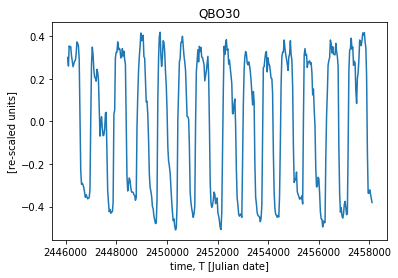

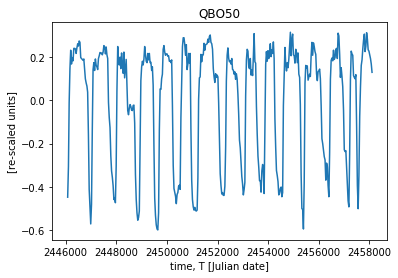

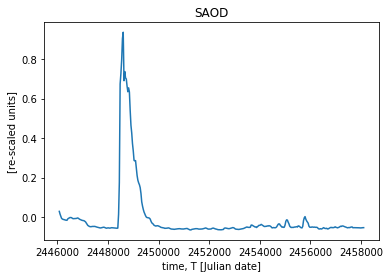

In [4]:
# Import the regressors

# Again you can do this however you want, but the result must be the following variables loaded into python
# nreg (int) = number of regressors
# regressors float[N, nreg] = 2d array with each column representing one regressor over the times corresponding to
# the data to be analysed

# NOTE: We also mean subtract and rescale all regressors in the same way as for the data so they have dymanic range 
# of 1 

# IMPORTANT: Missing values/NaNs are NOT supported, please interpolate missing values or similar so they are all 
# real valued

# ENSO
y = np.loadtxt('regressors/ENSO_MEI_ENSO_1950_201802.dat')
t = np.loadtxt('regressors/ENSOTime_MEI_ENSO_1950_201802.dat')
y = y - np.mean(y)
y = y/(max(y) - min(y))
Y = interpolate.InterpolatedUnivariateSpline(t, y)
enso = Y(T) # This extacts the regressor at the times you have in your dataset, interpolated in case the time grid is different to the actual data

# Solar
y = np.loadtxt('regressors/Flux_F30_monthly_195111_201803_absolute.dat')
t = np.loadtxt('regressors/Time_F30_monthly_195111_201803_absolute.dat')
y = y - np.mean(y)
y = y/(max(y) - min(y))
Y = interpolate.InterpolatedUnivariateSpline(t, y)
solar = Y(T)

# QBO30
y = np.loadtxt('regressors/multi_qbo30_1953_2018.dat')
t = np.loadtxt('regressors/multi_qbotime_1953_2018.dat')
y = y - np.mean(y)
y = y/(max(y) - min(y))
Y = interpolate.InterpolatedUnivariateSpline(t, y)
qbo30 = Y(T) 

# QBO50
y = np.loadtxt('regressors/multi_qbo50_1953_2018.dat')
t = np.loadtxt('regressors/multi_qbotime_1953_2018.dat')
y = y - np.mean(y)
y = y/(max(y) - min(y))
Y = interpolate.InterpolatedUnivariateSpline(t, y)
qbo50 = Y(T) # This extacts the regressor at the times you have in your dataset, interpolated in case the time grid is different

# SAOD
saod_data = netCDF4.Dataset('regressors/sad_1979_2017_10deg_60S_60N_missNans.nc')
y = saod_data['saod_strat_column'][:, latitude]
t = saod_data['time'][:]
y = y - np.mean(y)
y = y/(max(y) - min(y))
Y = interpolate.InterpolatedUnivariateSpline(t, y)
saod = Y(T)

# Stack the regressors into big 2d array
nreg = 5 # number of regressors
regressors = np.column_stack([enso, solar, qbo30, qbo50, saod]) # Stack of all the regressors together in a 2d array

# Plot all the regressors to check they look OK
plt.plot(T, enso)
plt.title('ENSO')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, solar)
plt.title('Solar F30')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, qbo30)
plt.title('QBO30')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, qbo50)
plt.title('QBO50')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

plt.plot(T, saod)
plt.title('SAOD')
plt.xlabel('time, T [Julian date]')
plt.ylabel('[re-scaled units]')
plt.show()

In [5]:
# Set the data and initialization of parameters that are fed into the DLM

# Data: this is a dictionary of all of the data/inputs that the DLM model needs (descriptions below)
data = {
                    'd':d, # float[N] data vector
                    's':s, # float[N] std-dev error bars
                    'N':N, # (int) number of time-steps in the time-series
                    'nreg':nreg, # (int) number of regressors
                    'regressors':regressors, # float[N, nreg] the regressors
                    'S':10., # prior variance on the regression coefficients (priors are zero mean Gaussian with variance S)
                    'sigma_trend_prior':1e-4, # std-dev of the half-Gaussian prior on sigma_trend that controls how wiggly the trend can be
                    'sigma_seas_prior':0.01, # std-dev of the half-Gaussian prior on sigma_seas that controls how dynamic the seaonal cycle can be
                    'sigma_AR_prior':0.5 # std-dev of the half_Gaussian prior on the AR1 process std-dev 
                }

# Initialization: Initial guess values for the hyper-parameters
initial_state = {
                 'sigma_trend':0.0001,
                 'sigma_seas':0.001,
                 'sigma_AR':0.01,
                 'rhoAR':0.1,
                }

In [6]:
# Run the DLM (and time it)

# The input parameters to the function "sampling()" below have the following meanings:
# data = data object from above
# iter = total number of MCMC samples to get
# warmup = how many evaluations are allowed for the HMC sampler to "warm-up" (these are not used in the final output)
# chains = how many parallel chains to run
# init = initial state object from above (NOTE: you must list more initial states if chains > 1 ie [initial_state1, initial_state2,...])
# pars = which parameters do you actually want to save as output in the results? You can choose any number from: 
# "sigma_trend", "sigma_seas", "sigma_AR", "rhoAR", "beta" float[nreg] (regression coefficients), 
# "trend" float[N] (non-inear DLM trend for each time-step), 
# "slope" float[N] (slope of the non-linear DLM trend for each time-step), 
# "seasonal" float[N] (total seasonal cycle with 6- and 12- month components, for each time-step), 
# "residuals" float[N] (data - (model-AR1)), 
# "ar" float[N] (fitted AR1 process)
# NOTE: you should limit your output to things you really want to look at after, since the output object will be 
# smaller and faster to work with for making plots etc later on

# Ok, let's run it (and print out the run-time)
start = time.time()
fit = model_kalman_ar1.sampling(data=data, iter=3000, warmup=1000, chains=1, init = [initial_state], verbose=True, pars=('sigma_trend', 'sigma_seas', 'sigma_AR', 'rhoAR', 'trend', 'slope', 'beta', 'seasonal', 'residuals'))
print(time.time() - start)

/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


455.8865668773651


In [7]:
# By this point, the "fit" object contains an MCMC chain of chains x iter samples of each of the "pars" that you
# chose to output. To access the MCMC chain for any individual parameter, just do:
# fit.extract()['insert parameter name here'] (see examples below)
# For example, if you do fit.extract()['trend'] it will give an array float[chains x iter, N], ie chains x iter
# samples of the full DLM trend which has lengh N

In [8]:
# Extract the various bits from the fit-object. 

# All outputs from the fit() object will have shape n_samples x object_dimension where the number of MCMC samples
# n_samples = iter x chains and object_dimension is the length of the object, eg. =1 for scalars like sigma_AR 
# and = N (n_time_steps) for objects that have a real value at all time steps like the DLM trend, seasonal cycle, etc

# NB, the trend, seasonal cycle, proxy coefficients, AR process and residuals are derived for the mean sub-tracted 
# and re-scaled data
# => we need to re-scale back to the data units (and add the mean back in for the trend)

# Trend
trend = fit.extract()['trend'][:,:]*scale + mean

# Gradient of the DLM trend
slope = fit.extract()['slope'][:,:]*scale

# Seasonal cycle
seasonal_cycle = fit.extract()['seasonal'][:,:]*scale

# Residuals
residuals = fit.extract()['residuals'][:,:]*scale

# Regressor coefficients (also need re-scaling back to data units)
regressor_coefficients = fit.extract()['beta'][:,:]*scale

# DLM hyper parameters
sigma_trend = fit.extract()['sigma_trend']
sigma_seas = fit.extract()['sigma_seas']
sigma_AR = fit.extract()['sigma_AR']*scale # Also needs re-scaling back to data units
rho_AR = fit.extract()['sigma_AR']

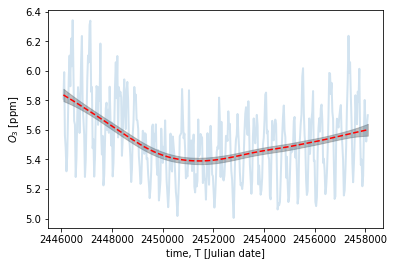

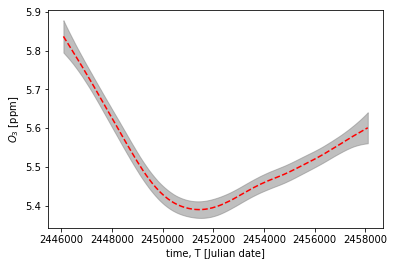

In [9]:
# Plot recovered trend against the data

# Plot the data scaled back to original units and with the mean added back in
plt.plot(T, d*scale + mean, lw = 2, alpha = 0.2)

# Plot the mean trend
plt.plot(T, np.mean(trend, axis = 0), color = 'red', ls = '--')

# Plot a grey band showing the error on the extracted DLM trend
# NOTE: this includes the error on the shape of the trend, but also on the overall offset, so can look deceptively large
plt.fill_between(T, np.mean(trend, axis = 0) - np.std(trend, axis = 0), np.mean(trend, axis = 0) + np.std(trend, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

# Same plot but without the data behind (for a closer look at the DLM trend)
plt.plot(T, np.mean(trend, axis = 0), color = 'red', ls = '--')
plt.fill_between(T, np.mean(trend, axis = 0) - np.std(trend, axis = 0), np.mean(trend, axis = 0) + np.std(trend, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'$O_3$ [ppm]')
plt.show()

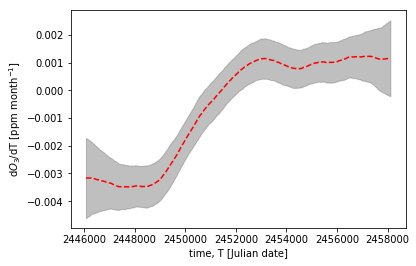

In [10]:
# Plot the slope of the recovered trend

plt.plot(T, np.mean(slope, axis = 0), color = 'red', ls = '--')
plt.fill_between(T, np.mean(slope, axis = 0) - np.std(slope, axis = 0), np.mean(slope, axis = 0) + np.std(slope, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel(r'd$O_3$/dT [ppm month$^{-1}$]')
plt.show()

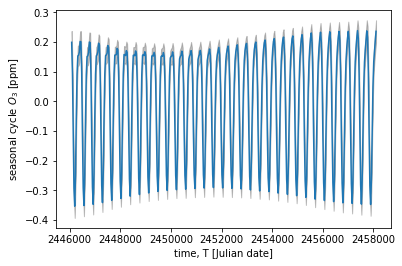

In [11]:
# Plot the recovered seasonal cycle and uncertainties
plt.plot(T, np.mean(seasonal_cycle, axis = 0))
plt.fill_between(T, np.mean(seasonal_cycle, axis = 0) - np.std(seasonal_cycle, axis = 0), np.mean(seasonal_cycle, axis = 0) + np.std(seasonal_cycle, axis = 0), color = 'grey', alpha = 0.5)
plt.xlabel('time, T [Julian date]')
plt.ylabel('seasonal cycle $O_3$ [ppm]')
plt.show()

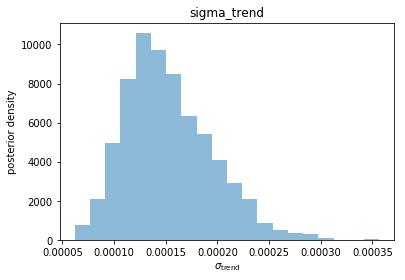

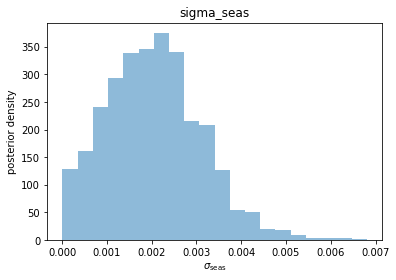

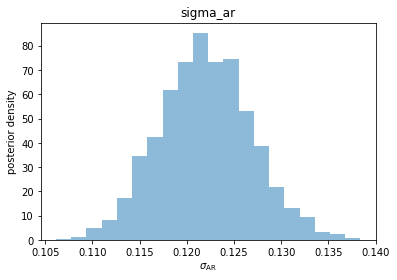

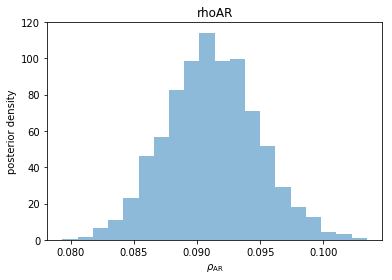

In [12]:
# Plot posteriors for the DLM hyper parameters
plt.hist(sigma_trend, bins=20, normed=True, alpha = 0.5)
plt.title('sigma_trend')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{trend}$')
plt.show()

plt.hist(sigma_seas, bins=20, normed=True, alpha = 0.5)
plt.title('sigma_seas')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{seas}$')
plt.show()

plt.hist(sigma_AR, bins=20, normed=True, alpha = 0.5)
plt.title('sigma_ar')
plt.ylabel('posterior density')
plt.xlabel(r'$\sigma_\mathrm{AR}$')
plt.show()

plt.hist(rho_AR, bins=20, normed=True, alpha = 0.5)
plt.title('rhoAR')
plt.ylabel('posterior density')
plt.xlabel(r'$\rho_\mathrm{AR}$')
plt.show()


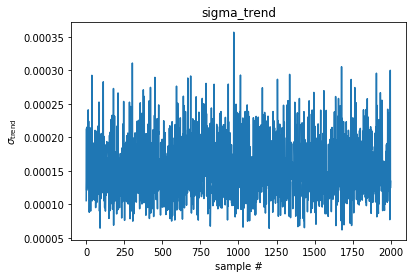

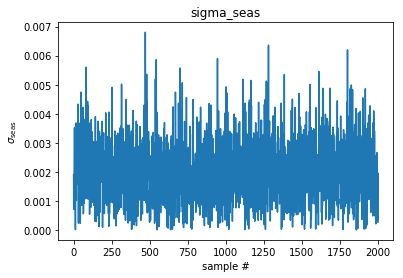

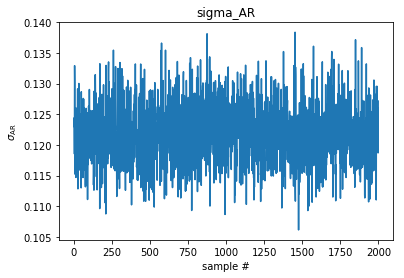

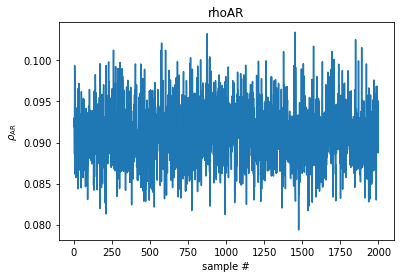

In [13]:
# Do trace plots of the MCMC chains of the hyper-parameters

# NOTE: This is a good visual check whether the chains have converged, it should looks like noise
# if you see any "drifts" in these trace plots then you need to run longer chains (ie, increase "iter" above)

plt.plot(sigma_trend)
plt.title('sigma_trend')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{trend}$')
plt.show()

plt.plot(sigma_seas)
plt.title('sigma_seas')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{seas}$')
plt.show()

plt.plot(sigma_AR)
plt.title('sigma_AR')
plt.xlabel('sample #')
plt.ylabel(r'$\sigma_\mathrm{AR}$')
plt.show()

plt.plot(rho_AR)
plt.title('rhoAR')
plt.xlabel('sample #')
plt.ylabel(r'$\rho_\mathrm{AR}$')
plt.show()

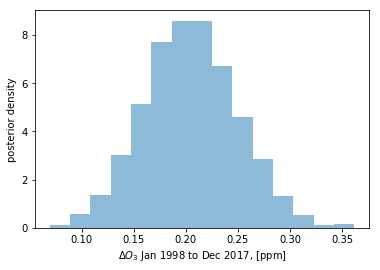

In [14]:
# Plot the posterior on the overall change in O3 between two dates eg, jan1998 and dec2017

# Time indices for the two dates
jan1998 = 156 # index of the T array corresponding to Jan 1998
dec2017 = -1 # (end of time series; december 2017)

# Construct MCMC samples for the change in O3 between those two dates by differencing the trend samples at those dates
deltaO3_jan1998_dec2017 = trend[:,dec2017] - trend[:,jan1998]

# Plot the histogram of the posterior samples of DeltaO3 between Jan 1998 and Dec 2017
plt.hist(deltaO3_jan1998_dec2017, bins = 15, alpha = 0.5, normed = True)
plt.xlabel(r'$\Delta O_3$ Jan 1998 to Dec 2017, [ppm]')
plt.ylabel('posterior density')
plt.show()